<a href="https://colab.research.google.com/github/shivanishah/satellite-image/blob/main-v2.1/satellite_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import csv
import cv2

In [4]:
!pip install Pillow
!pip install numpy
!pip install rasterio
!pip install matplotlib
!pip install scikit-learn
!pip install patchify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.3 MB/s eta 0:00:00


In [2]:
#if you have issue while installing tensorflow and segmentation models
!pip uninstall -y segmentation-models efficientnet image-classifiers keras tensorflow

In [3]:
!pip install tensorflow==2.9.1 keras==2.9.0
!pip install segmentation-models==1.0.1
!pip install efficientnet==1.0.0 image-classifiers==1.0.0

  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.9.1 which is incompatible.
  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
  Using cached image_classifiers-1.0.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)


In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.merge import merge
from PIL import Image
from patchify import patchify
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

Segmentation Models: using `keras` framework.


In [7]:
# Define the input and output folder paths
base_input_folder = "drive/MyDrive/Colab Notebooks/satellite"
categories = ["Farm", "Dense Residential", "Forest"] #"Sparse Residential"
label_mapping = {
  'farm': 0,
  'dense residential': 1,
  'forest': 2
  #'sparse residential': 3
}
color_mapping = {
    0: [144/255, 238/255, 144/255],  # Light green for Farm
    1: [0/255, 0/255, 139/255],      # Dark blue for Dense Residential
    2: [0/255, 100/255, 0/255]      # Dark green for Forest
    #3: [135/255, 206/255, 250/255]   # Light blue for Sparse Residential
}

In [8]:
def apply_color_mapping(mask):
  # Create an empty RGB image
  colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
  # Apply color mapping
  for label, color in color_mapping.items():
      colored_mask[mask == label] = color
  return colored_mask

In [11]:
minmaxscaler = MinMaxScaler()
patch_size = 128

In [12]:
# Initialize an empty list to store labels from masks
labels_dataset = []
# Initialize an empty list to store patches from images
image_dataset = []
# Initialize an empty list to store mask from images,labels
mask_dataset = []

# Iterate over each category to process image
for category in categories:
    # Construct the path to the pngImage folder within each category
    image_folder = os.path.join(base_input_folder, category, "pngImage")

    # Check if the folder exists before proceeding
    if not os.path.exists(image_folder):
        print(f"Warning: {image_folder} does not exist, skipping.")
        continue

    # List and process all PNG images in the folder
    images = sorted(os.listdir(image_folder))
    for i, image_name in enumerate(images):
        if image_name.endswith(".png"):  # Only process PNG images
            image_path = os.path.join(image_folder, image_name)

            # Read and process the image
            image = cv2.imread(image_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #base 10 (decimal) colors

            # Check if the image dimensions are smaller than the patch size
            if image.shape[0] < patch_size or image.shape[1] < patch_size:
                print(f"Warning: Image {image_path} is smaller than patch size, skipping.")
                continue

            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by patch size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by patch size

            # Crop the image to the nearest size divisible by patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            # Extract patches from the image
            #print(f"Now patchifying mask: {image_path}")
            patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=128 means no overlap

            # Iterate through patches and add them to the dataset
            for i in range(patches_image.shape[0]):
                for j in range(patches_image.shape[1]):
                    individual_patched_image = patches_image[i,j,:,:]
                    #print(individual_patched_image.shape)
                    #normalise dataset with minmaxscaler
                    individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                    individual_patched_image = individual_patched_image[0]
                    #print(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)

                    # Create mask patch
                    mask_patch = np.full((patch_size, patch_size), label_mapping.get(category.lower(), 0))
                    mask_dataset.append(mask_patch)

                    # Add the label to the dataset based on the category
                    labels_dataset.append(category.lower())

In [13]:
print(f"Total number of image patches extracted: {len(image_dataset)}")
print(f"Total number of mask paches extracted: {len(mask_dataset)}")
print(f"Total number of label paches extracted: {len(labels_dataset)}")

Total number of image patches extracted: 1200
Total number of mask paches extracted: 1200
Total number of label paches extracted: 1200


In [14]:
mask_dataset[500].shape

(128, 128)

In [15]:
image_dataset[500].shape

(128, 128, 3)

In [16]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
labels_dataset = np.array(labels_dataset)

In [17]:
image_dataset[500]

array([[[0.9535865 , 0.91025641, 0.81702128],
        [0.92405063, 0.87606838, 0.79574468],
        [0.88185654, 0.86324786, 0.78297872],
        ...,
        [0.00843882, 0.02136752, 0.01276596],
        [0.01265823, 0.0042735 , 0.01702128],
        [0.092827  , 0.0042735 , 0.05106383]],

       [[0.92827004, 0.92735043, 0.85106383],
        [0.92405063, 0.90598291, 0.80425532],
        [0.87341772, 0.89316239, 0.78723404],
        ...,
        [0.02109705, 0.02564103, 0.03404255],
        [0.05485232, 0.04273504, 0.05957447],
        [0.24894515, 0.15384615, 0.14468085]],

       [[0.89029536, 0.92307692, 0.7787234 ],
        [0.86919831, 0.85897436, 0.76595745],
        [0.86919831, 0.85897436, 0.74893617],
        ...,
        [0.02109705, 0.02564103, 0.02553191],
        [0.08860759, 0.05982906, 0.08085106],
        [0.32489451, 0.26068376, 0.23404255]],

       ...,

       [[0.75527426, 0.73931624, 0.73617021],
        [0.92405063, 0.93589744, 0.83829787],
        [0.89873418, 0

#Data Augmentation

In [18]:
from scipy import ndimage

In [19]:
def apply_augmentation(image, mask):
  # Apply random rotations
  if np.random.rand() < 0.5:
    angle = np.random.randint(4) * 90
    image = ndimage.rotate(image, angle, reshape=False)
    mask = ndimage.rotate(mask, angle, reshape=False)

  # Apply vertical flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 0)
    mask = np.flip(mask, 0)

  # Apply horizontal flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 1)
    mask = np.flip(mask, 1)

  # Apply zooming
  if np.random.rand() < 0.5:
    zoom_factor = np.random.uniform(0.8, 1.2)
    image = ndimage.zoom(image, (zoom_factor, zoom_factor, 1), order=1)
    mask = ndimage.zoom(mask, (zoom_factor, zoom_factor), order=0)

  # Apply brightness adjustment
  if np.random.rand() < 0.5:
    brightness_factor = np.random.uniform(0.7, 1.3)
    image = np.clip(image * brightness_factor, 0, 1).astype(np.float32)

  # Apply contrast adjustment
  if np.random.rand() < 0.5:
    contrast_factor = np.random.uniform(0.7, 1.3)
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 1).astype(np.float32)

  # Resize the image and mask
  image = cv2.resize(image, (128, 128))  # Keeping the original size
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

  return image, mask

In [20]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

# Add original image
augmented_image_dataset.append(image_dataset[0])
augmented_mask_dataset.append(mask_dataset[0])
augmented_labels_dataset.append(labels_dataset[0])

# Add augmented image
aug_image, aug_mask = apply_augmentation(image_dataset[0], mask_dataset[0])
augmented_image_dataset.append(aug_image)
augmented_mask_dataset.append(aug_mask)
augmented_labels_dataset.append(labels_dataset[0])

In [ ]:
## testing purpose - start

In [21]:
image_dataset[0]


array([[[0.04519774, 0.04210526, 0.05617978],
        [0.0960452 , 0.08947368, 0.11797753],
        [0.06214689, 0.05789474, 0.08426966],
        ...,
        [0.44632768, 0.42631579, 0.43258427],
        [0.48587571, 0.45263158, 0.46067416],
        [0.47457627, 0.44736842, 0.45505618]],

       [[0.02824859, 0.02631579, 0.03932584],
        [0.05649718, 0.05263158, 0.06179775],
        [0.04519774, 0.04210526, 0.05617978],
        ...,
        [0.28813559, 0.29473684, 0.29213483],
        [0.35028249, 0.33157895, 0.33707865],
        [0.44067797, 0.41578947, 0.42696629]],

       [[0.03389831, 0.03157895, 0.04494382],
        [0.04519774, 0.04210526, 0.0505618 ],
        [0.03954802, 0.03684211, 0.0505618 ],
        ...,
        [0.38418079, 0.42631579, 0.3988764 ],
        [0.26553672, 0.28421053, 0.2752809 ],
        [0.23163842, 0.23684211, 0.24157303]],

       ...,

       [[0.63276836, 0.57368421, 0.58988764],
        [0.61016949, 0.54210526, 0.56179775],
        [0.59887006, 0

In [22]:
mask_dataset[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
augmented_mask_dataset[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [24]:
augmented_labels_dataset[1]

'farm'

In [25]:
labels_dataset[1]

'farm'

In [26]:
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_image_dataset.shape

(2, 128, 128, 3)

In [27]:
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_mask_dataset.shape

(2, 128, 128)

In [28]:
augmented_labels_dataset = np.array(augmented_labels_dataset)
augmented_labels_dataset.shape

(2,)

In [ ]:
## testing purpose end

In [29]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

for image, mask, label in zip(image_dataset, mask_dataset, labels_dataset):
  # Add original image
  augmented_image_dataset.append(image)
  augmented_mask_dataset.append(mask)
  augmented_labels_dataset.append(label)

  # Add augmented image
  aug_image, aug_mask = apply_augmentation(image, mask)
  augmented_image_dataset.append(aug_image)
  augmented_mask_dataset.append(aug_mask)
  augmented_labels_dataset.append(label)

# Convert to numpy arrays
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_labels_dataset = np.array(augmented_labels_dataset)

# Print the new sizes
print(f"Augmented image dataset shape: {augmented_image_dataset.shape}")
print(f"Augmented mask dataset shape: {augmented_mask_dataset.shape}")
print(f"Augmented labels dataset shape: {augmented_labels_dataset.shape}")

Augmented image dataset shape: (2400, 128, 128, 3)
Augmented mask dataset shape: (2400, 128, 128)
Augmented labels dataset shape: (2400,)


In [30]:
augmented_mask_dataset = np.expand_dims(augmented_mask_dataset, axis=3)
augmented_mask_dataset.shape

(2400, 128, 128, 1)

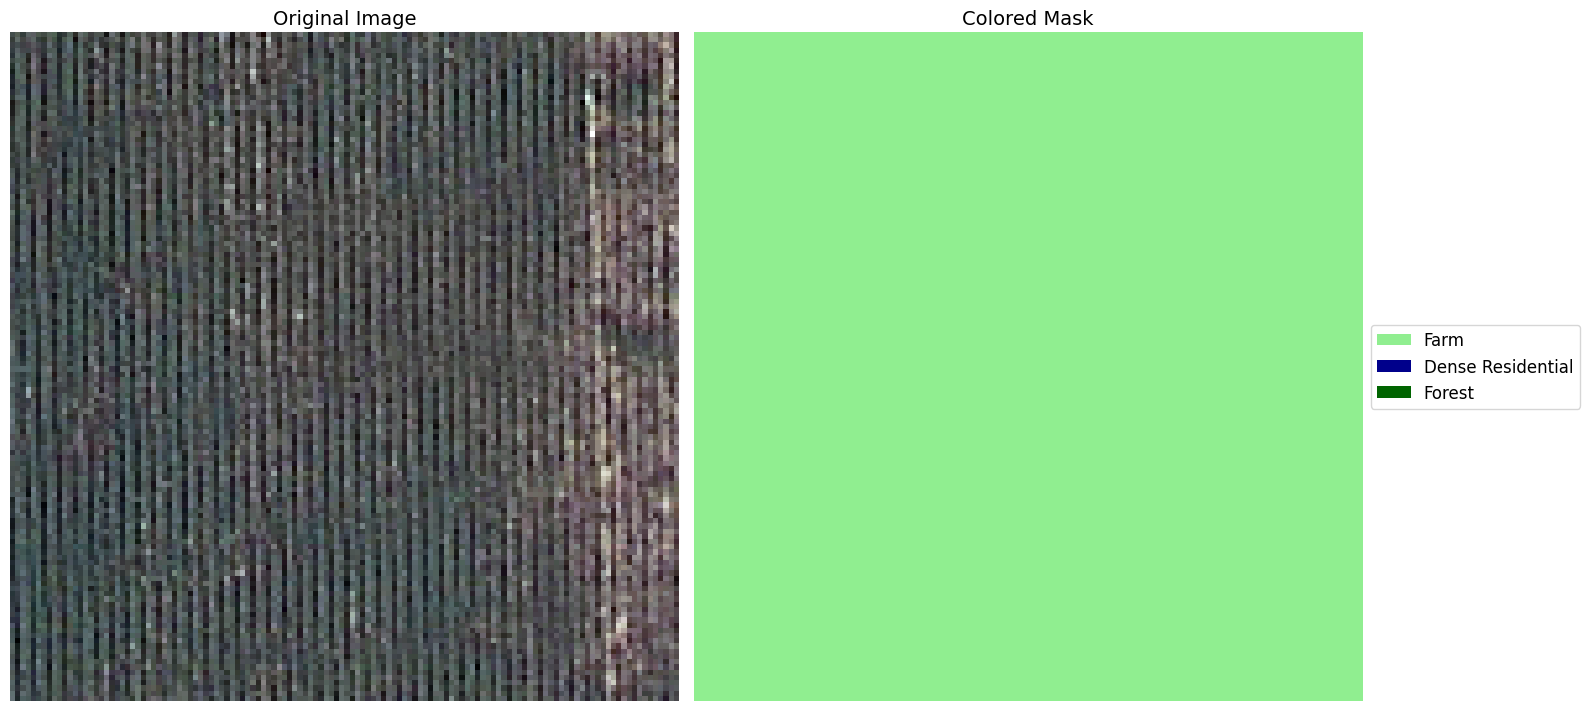

Category: Farm


In [33]:
# Select a random image and its corresponding mask
random_image_id = random.randint(0, len(augmented_image_dataset) - 1)
random_image = augmented_image_dataset[random_image_id]
random_mask = augmented_mask_dataset[random_image_id]

# Apply color mapping to the mask
colored_mask = apply_color_mapping(random_mask)
# Squeeze the colored mask to remove the extra dimension
colored_mask = np.squeeze(colored_mask)

# Create the plot
plt.figure(figsize=(16, 8))

# Display original image
plt.subplot(121)
plt.title("Original Image", fontsize=14)
plt.imshow(random_image)
plt.axis('off')

# Display colored mask
plt.subplot(122)
plt.title("Colored Mask", fontsize=14)
plt.imshow(colored_mask)
plt.axis('off')

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_mapping[label_mapping[cat.lower()]], label=cat) for cat in categories]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

# Print the category of the selected image
print(f"Category: {categories[label_mapping[augmented_labels_dataset[random_image_id]]]}")

#EDA

In [ ]:
from collections import Counter

Class distribution:
farm: 400
dense residential: 400
forest: 400
sparse residential: 394


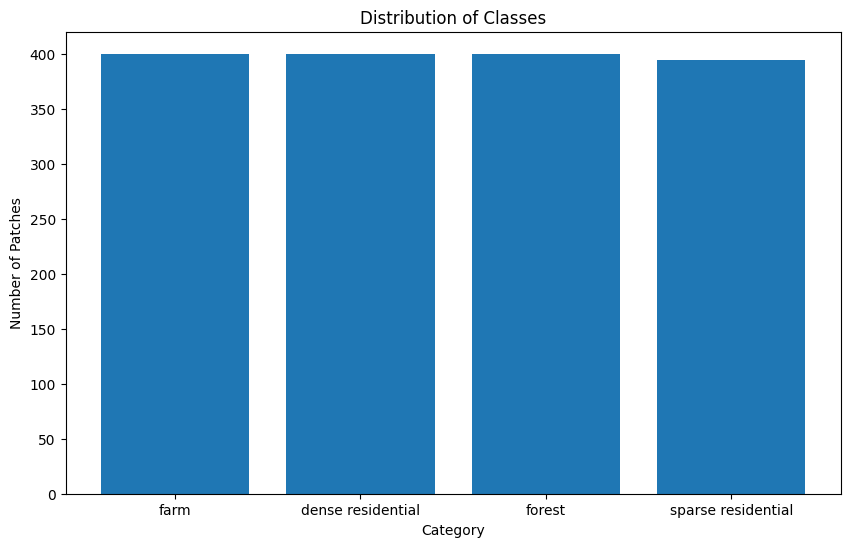

In [ ]:
#Count the occurrences of each class:
class_distribution = Counter(labels_dataset)

print("Class distribution:")
for category, count in class_distribution.items():
  print(f"{category}: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribution of Classes")
plt.xlabel("Category")
plt.ylabel("Number of Patches")
plt.show()

In [ ]:
#Calculate the percentage of each class:
total_patches = len(labels_dataset)
for category, count in class_distribution.items():
  percentage = (count / total_patches) * 100
  print(f"{category}: {percentage:.2f}%")

farm: 25.09%
dense residential: 25.09%
forest: 25.09%
sparse residential: 24.72%


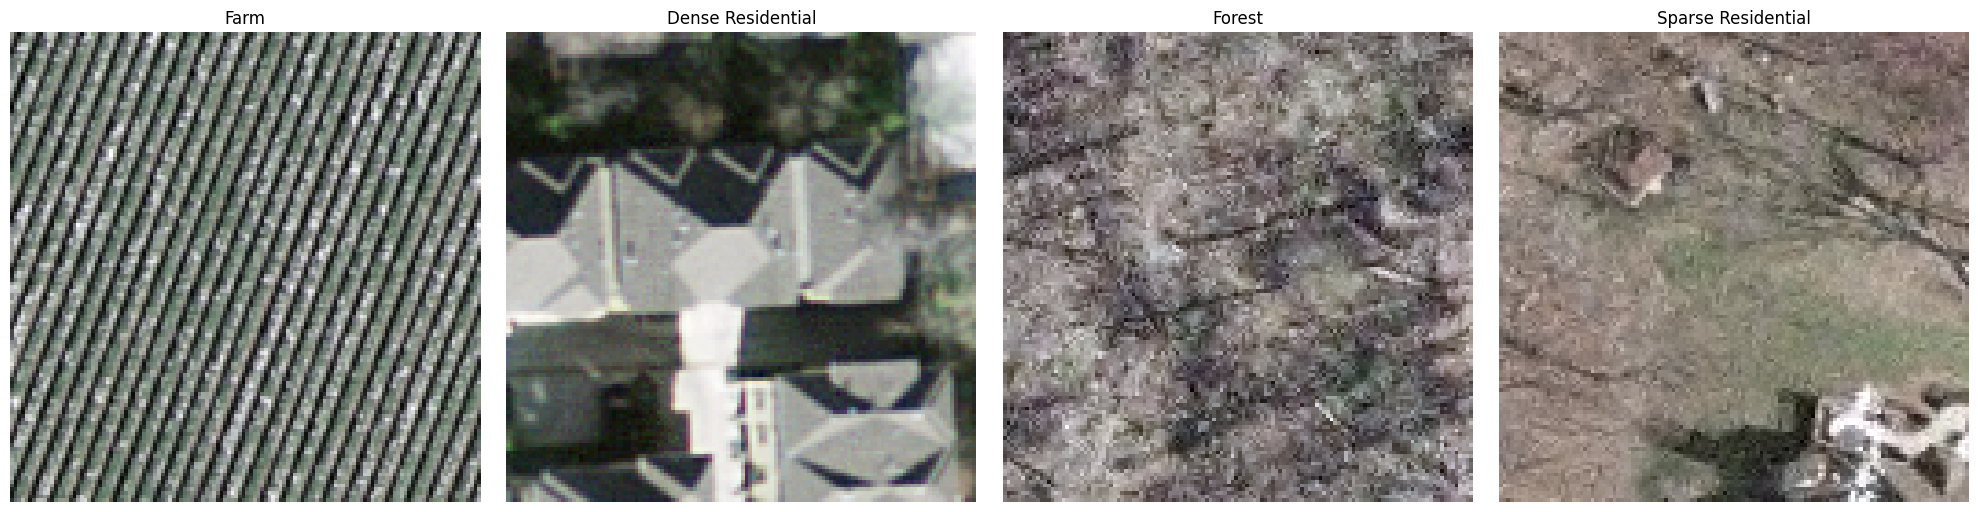

In [ ]:
#Display sample images from each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  random_index = np.random.choice(category_indices)
  plt.subplot(1, 4, i+1)
  plt.imshow(image_dataset[random_index])
  plt.title(category)
  plt.axis('off')
plt.tight_layout()
plt.show()

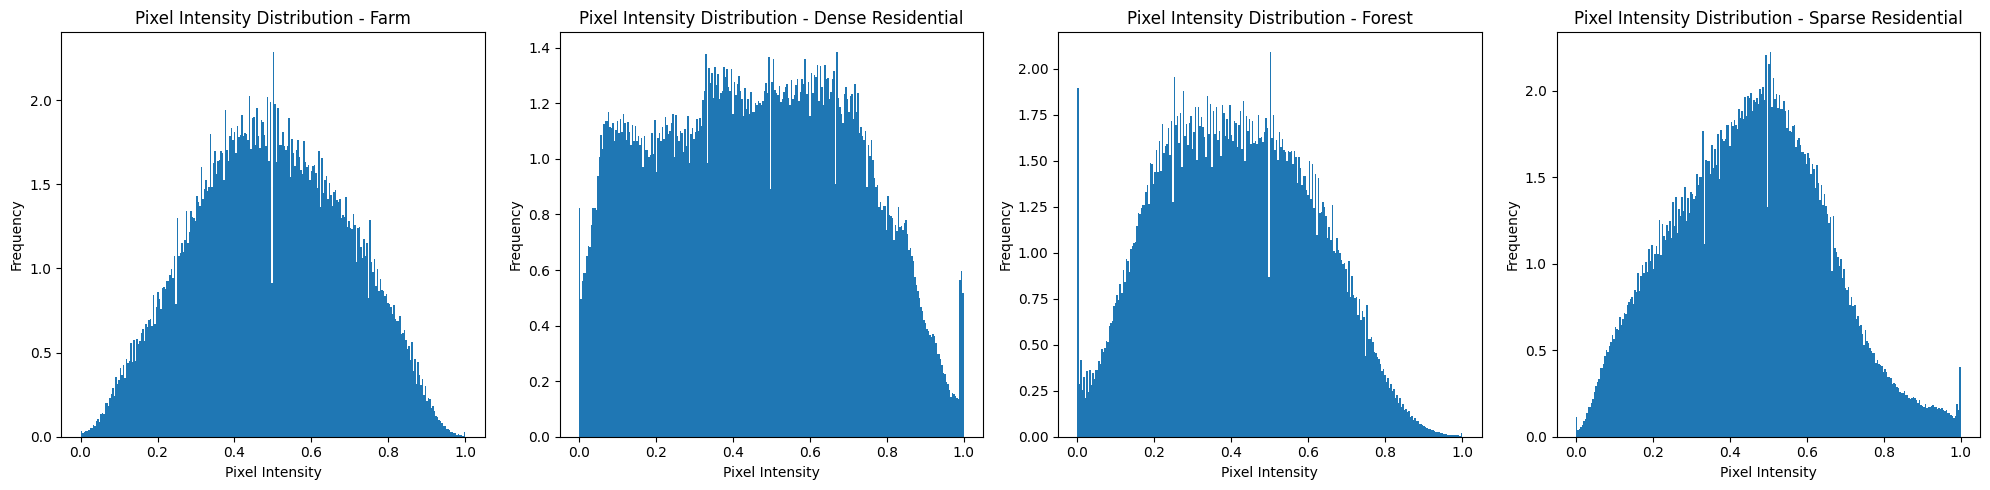

In [ ]:
#Analyze pixel intensity distribution for each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  category_images = image_dataset[category_indices]
  plt.subplot(1, 4, i+1)
  plt.hist(category_images.ravel(), bins=256, range=(0, 1), density=True)
  plt.title(f"Pixel Intensity Distribution - {category}")
  plt.xlabel("Pixel Intensity")
  plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

1. Farm: The distribution is roughly symmetric, peaking around the middle intensity values. This suggests a balanced range of pixel intensities, indicating a mix of light and dark areas.
2. Dense Residential: The distribution is more uniform, with a slight peak towards higher intensities. This could indicate a prevalence of brighter areas, possibly due to reflective surfaces or artificial lighting.
3. Forest: The distribution is similar to the Farm category, with a peak around the middle. This suggests a mix of shadows and sunlight typical of forested areas.
4. Sparse Residential: The distribution is also symmetric, with a peak around the middle. This indicates a mix of open spaces and structures, leading to varied pixel intensities.

# Training and testing Dataset

In [34]:
image_dataset = augmented_image_dataset
mask_dataset = augmented_mask_dataset
labels_dataset = augmented_labels_dataset
mask_dataset.shape

(2400, 128, 128, 1)

In [35]:
total_classes = len(np.unique(mask_dataset))
total_classes

3

In [36]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [37]:
mask_dataset[90]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [38]:
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

In [39]:
labels_categorical_dataset[90]

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]], dtype=float32)

In [40]:
labels_categorical_dataset

array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        ...,

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]],


       [[[1., 0., 0.],
         [1., 0., 0.],
         [1., 

In [41]:
image_dataset.shape

(2400, 128, 128, 3)

In [42]:
master_trianing_dataset = image_dataset

In [43]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.30, random_state=100)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 128, 128, 3)
(720, 128, 128, 3)
(1680, 128, 128, 3)
(720, 128, 128, 3)


In [45]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
3


# Deep Learning with Satellite Imagery Data

In [46]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [47]:
from keras import backend as K

In [48]:
#https://en.wikipedia.org/wiki/Jaccard_index
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [62]:
def multi_unet_model(n_classes=3, image_height=128, image_width=128, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.1)(c1) #drop 20% value
  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.1)(c3)
  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.1)(c4)
  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.1)(c5)
  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.1)(c6)
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [63]:
metrics = ["accuracy", jaccard_coef]

In [64]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [65]:
model = get_deep_learning_model()

In [66]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': 'd

#Generating Loss Function

*   dice loss > Focal Loss > Total Loss
*   Total Loss = (Dice loss + (1*Focal Loss))



In [54]:
import segmentation_models as sm

In [55]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

In [67]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [68]:
total_loss

#Model compilation

In [58]:
import tensorflow as tf

In [59]:
tf.keras.backend.clear_session()

In [69]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['dropout[0][0]']            

#Visualize Model with Keras

In [75]:
!pip install pydot
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.4 MB/s eta 0:00:00


In [76]:
from keras.utils.vis_utils import plot_model

In [77]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [78]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [79]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00


In [80]:
!pip install --upgrade wandb

In [81]:
# Log in to your W&B account
import wandb
# Use wandb-core, temporary for wandb's new backend
wandb.require("core")
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbCallback

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [82]:
wandb.init(project="satellite-imagery", entity="shah-shivani1993-university-of-south-australia")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [83]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [84]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [85]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})
wandb.config.dropout = 0.1

(1920, 128, 128, 3)
(480, 128, 128, 3)
(1920, 128, 128, 3)
(480, 128, 128, 3)

In [99]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

### Model start

##Model 1 with 70 epoch and 32 batch size

In [102]:
model = get_deep_learning_model()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [103]:
#accuracy of train dataset
model_history1 = model.fit(X_train, y_train,
                          batch_size=32, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=70, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          #callbacks=[plot_loss],
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

Epoch 1/70
53/53 [==============================] - 19s 311ms/step - loss: 0.9310 - accuracy: 0.3503 - jaccard_coef: 0.2027 - val_loss: 0.9207 - val_accuracy: 0.4297 - val_jaccard_coef: 0.2197
Epoch 2/70
53/53 [==============================] - 16s 302ms/step - loss: 0.9125 - accuracy: 0.4858 - jaccard_coef: 0.2411 - val_loss: 0.9116 - val_accuracy: 0.4387 - val_jaccard_coef: 0.2719
Epoch 3/70
53/53 [==============================] - 16s 306ms/step - loss: 0.8699 - accuracy: 0.5780 - jaccard_coef: 0.3440 - val_loss: 0.8350 - val_accuracy: 0.6433 - val_jaccard_coef: 0.3828
Epoch 4/70
53/53 [==============================] - 16s 300ms/step - loss: 0.8277 - accuracy: 0.6593 - jaccard_coef: 0.4312 - val_loss: 0.8278 - val_accuracy: 0.6413 - val_jaccard_coef: 0.3985
Epoch 5/70
53/53 [==============================] - 16s 299ms/step - loss: 0.8057 - accuracy: 0.7329 - jaccard_coef: 0.5035 - val_loss: 0.8041 - val_accuracy: 0.7342 - val_jaccard_coef: 0.4953
Epoch 6/70
53/53 [=================

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 19s 366ms/step - loss: 0.6854 - accuracy: 0.9766 - jaccard_coef: 0.9422 - val_loss: 0.6844 - val_accuracy: 0.9797 - val_jaccard_coef: 0.9543
Epoch 24/70
53/53 [==============================] - 16s 295ms/step - loss: 0.6832 - accuracy: 0.9801 - jaccard_coef: 0.9526 - val_loss: 0.6867 - val_accuracy: 0.9752 - val_jaccard_coef: 0.9489
Epoch 25/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6783 - accuracy: 0.9875 - jaccard_coef: 0.9683 - val_loss: 0.6861 - val_accuracy: 0.9796 - val_jaccard_coef: 0.9570
Epoch 26/70
53/53 [==============================] - 16s 299ms/step - loss: 0.6856 - accuracy: 0.9747 - jaccard_coef: 0.9421 - val_loss: 0.6868 - val_accuracy: 0.9759 - val_jaccard_coef: 0.9465
Epoch 27/70
53/53 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.9877 - jaccard_coef: 0.9691

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 372ms/step - loss: 0.6786 - accuracy: 0.9877 - jaccard_coef: 0.9691 - val_loss: 0.6833 - val_accuracy: 0.9819 - val_jaccard_coef: 0.9639
Epoch 28/70
53/53 [==============================] - 16s 301ms/step - loss: 0.6792 - accuracy: 0.9862 - jaccard_coef: 0.9673 - val_loss: 0.6859 - val_accuracy: 0.9784 - val_jaccard_coef: 0.9546
Epoch 29/70
53/53 [==============================] - 16s 300ms/step - loss: 0.6750 - accuracy: 0.9921 - jaccard_coef: 0.9811 - val_loss: 0.6851 - val_accuracy: 0.9827 - val_jaccard_coef: 0.9648
Epoch 30/70
53/53 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.9916 - jaccard_coef: 0.9796

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 383ms/step - loss: 0.6757 - accuracy: 0.9916 - jaccard_coef: 0.9796 - val_loss: 0.6831 - val_accuracy: 0.9848 - val_jaccard_coef: 0.9688
Epoch 31/70
53/53 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.9949 - jaccard_coef: 0.9874

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 19s 369ms/step - loss: 0.6736 - accuracy: 0.9949 - jaccard_coef: 0.9874 - val_loss: 0.6830 - val_accuracy: 0.9838 - val_jaccard_coef: 0.9638
Epoch 32/70
53/53 [==============================] - 16s 298ms/step - loss: 0.6748 - accuracy: 0.9923 - jaccard_coef: 0.9819 - val_loss: 0.6875 - val_accuracy: 0.9791 - val_jaccard_coef: 0.9580
Epoch 33/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6758 - accuracy: 0.9917 - jaccard_coef: 0.9779 - val_loss: 0.6845 - val_accuracy: 0.9832 - val_jaccard_coef: 0.9658
Epoch 34/70
53/53 [==============================] - 16s 301ms/step - loss: 0.6739 - accuracy: 0.9951 - jaccard_coef: 0.9875 - val_loss: 0.6831 - val_accuracy: 0.9856 - val_jaccard_coef: 0.9705
Epoch 35/70
53/53 [==============================] - 16s 299ms/step - loss: 0.6786 - accuracy: 0.9878 - jaccard_coef: 0.9713 - val_loss: 0.6848 - val_accuracy: 0.9807 - val_jaccard_coef: 0.9586
Epoch 36/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 380ms/step - loss: 0.6736 - accuracy: 0.9946 - jaccard_coef: 0.9861 - val_loss: 0.6813 - val_accuracy: 0.9864 - val_jaccard_coef: 0.9727
Epoch 37/70
53/53 [==============================] - 16s 300ms/step - loss: 0.6727 - accuracy: 0.9965 - jaccard_coef: 0.9913 - val_loss: 0.6835 - val_accuracy: 0.9859 - val_jaccard_coef: 0.9727
Epoch 38/70
53/53 [==============================] - 16s 301ms/step - loss: 0.6835 - accuracy: 0.9819 - jaccard_coef: 0.9586 - val_loss: 0.7024 - val_accuracy: 0.9525 - val_jaccard_coef: 0.9084
Epoch 39/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6886 - accuracy: 0.9757 - jaccard_coef: 0.9378 - val_loss: 0.6836 - val_accuracy: 0.9823 - val_jaccard_coef: 0.9564
Epoch 40/70
53/53 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.9937 - jaccard_coef: 0.9836

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 376ms/step - loss: 0.6743 - accuracy: 0.9937 - jaccard_coef: 0.9836 - val_loss: 0.6806 - val_accuracy: 0.9868 - val_jaccard_coef: 0.9737
Epoch 41/70
53/53 [==============================] - 16s 298ms/step - loss: 0.6741 - accuracy: 0.9942 - jaccard_coef: 0.9857 - val_loss: 0.6817 - val_accuracy: 0.9856 - val_jaccard_coef: 0.9718
Epoch 42/70
53/53 [==============================] - 16s 298ms/step - loss: 0.6726 - accuracy: 0.9964 - jaccard_coef: 0.9908 - val_loss: 0.6894 - val_accuracy: 0.9788 - val_jaccard_coef: 0.9586
Epoch 43/70
53/53 [==============================] - 16s 298ms/step - loss: 0.6724 - accuracy: 0.9966 - jaccard_coef: 0.9916 - val_loss: 0.6814 - val_accuracy: 0.9874 - val_jaccard_coef: 0.9750
Epoch 44/70
53/53 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.9992 - jaccard_coef: 0.9975

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 19s 368ms/step - loss: 0.6706 - accuracy: 0.9992 - jaccard_coef: 0.9975 - val_loss: 0.6790 - val_accuracy: 0.9899 - val_jaccard_coef: 0.9796
Epoch 45/70
53/53 [==============================] - 16s 301ms/step - loss: 0.6711 - accuracy: 0.9985 - jaccard_coef: 0.9962 - val_loss: 0.6846 - val_accuracy: 0.9841 - val_jaccard_coef: 0.9691
Epoch 46/70
53/53 [==============================] - 16s 299ms/step - loss: 0.6797 - accuracy: 0.9875 - jaccard_coef: 0.9692 - val_loss: 0.6808 - val_accuracy: 0.9861 - val_jaccard_coef: 0.9732
Epoch 47/70
53/53 [==============================] - 16s 299ms/step - loss: 0.6723 - accuracy: 0.9968 - jaccard_coef: 0.9918 - val_loss: 0.6800 - val_accuracy: 0.9881 - val_jaccard_coef: 0.9755
Epoch 48/70
53/53 [==============================] - 16s 300ms/step - loss: 0.6707 - accuracy: 0.9992 - jaccard_coef: 0.9976 - val_loss: 0.6794 - val_accuracy: 0.9896 - val_jaccard_coef: 0.9791
Epoch 49/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 379ms/step - loss: 0.6705 - accuracy: 0.9995 - jaccard_coef: 0.9984 - val_loss: 0.6783 - val_accuracy: 0.9916 - val_jaccard_coef: 0.9833
Epoch 52/70
53/53 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.9992 - jaccard_coef: 0.9979

wandb: Adding directory to artifact (/content/wandb/run-20241005_025603-hc5451ah/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 381ms/step - loss: 0.6706 - accuracy: 0.9992 - jaccard_coef: 0.9979 - val_loss: 0.6779 - val_accuracy: 0.9921 - val_jaccard_coef: 0.9843
Epoch 53/70
53/53 [==============================] - 16s 304ms/step - loss: 0.6710 - accuracy: 0.9987 - jaccard_coef: 0.9969 - val_loss: 0.6897 - val_accuracy: 0.9818 - val_jaccard_coef: 0.9649
Epoch 54/70
53/53 [==============================] - 16s 296ms/step - loss: 0.6767 - accuracy: 0.9921 - jaccard_coef: 0.9787 - val_loss: 0.6804 - val_accuracy: 0.9882 - val_jaccard_coef: 0.9762
Epoch 55/70
53/53 [==============================] - 16s 302ms/step - loss: 0.6722 - accuracy: 0.9969 - jaccard_coef: 0.9922 - val_loss: 0.6852 - val_accuracy: 0.9863 - val_jaccard_coef: 0.9731
Epoch 56/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6707 - accuracy: 0.9991 - jaccard_coef: 0.9974 - val_loss: 0.6816 - val_accuracy: 0.9890 - val_jaccard_coef: 0.9785
Epoch 57/70
53/53 [=======================

In [104]:
# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# If you specifically want to access accuracy
test_accuracy = test_results[model.metrics_names.index('accuracy')]
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

loss: 0.6812
accuracy: 0.9891
jaccard_coef: 0.9786

Testing Accuracy: 0.9891


In [105]:
# Evaluate the model on the train dataset
train_results = model.evaluate(X_train, y_train, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {train_results[i]:.4f}")

# If you specifically want to access accuracy
train_accuracy = train_results[model.metrics_names.index('accuracy')]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

loss: 0.6706
accuracy: 0.9993
jaccard_coef: 0.9982

Training Accuracy: 0.9993


23/23 [==============================] - 1s 43ms/step


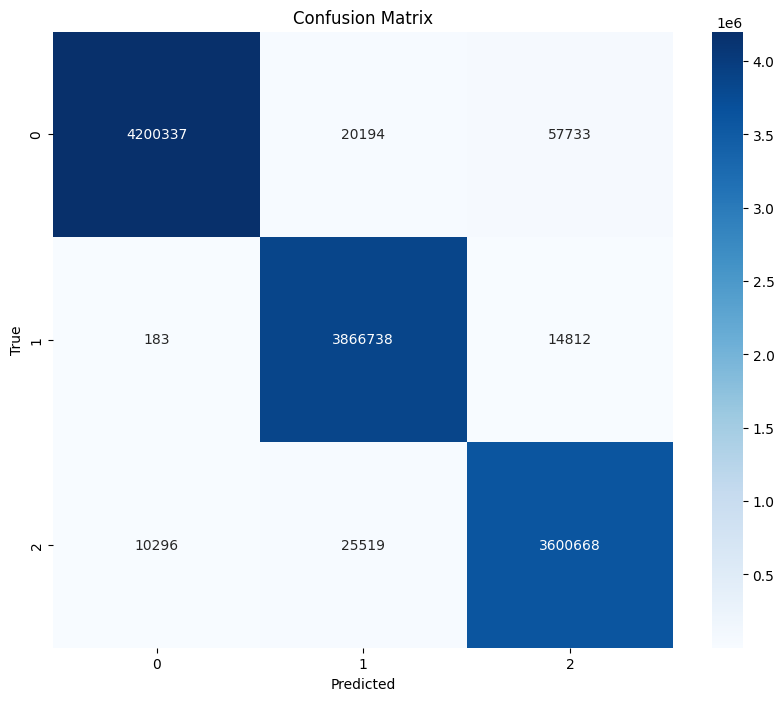

                   precision    recall  f1-score   support

      Agriculture       1.00      0.98      0.99   4278264
          Housing       0.99      1.00      0.99   3881733
Native Vegetation       0.98      0.99      0.99   3636483

         accuracy                           0.99  11796480
        macro avg       0.99      0.99      0.99  11796480
     weighted avg       0.99      0.99      0.99  11796480



In [106]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test, axis=3)

# Flatten the 2D arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Agriculture', 'Housing', 'Native Vegetation']))

In [107]:
for i, label in enumerate(['Agriculture', 'Housing', 'Native Vegetation']):
  label_accuracy = (y_pred_classes == i).astype(int) == (y_true == i).astype(int)
  label_accuracy = label_accuracy.mean() * 100
  print(f"{label} Accuracy: {label_accuracy:.2f}%")

Agriculture Accuracy: 99.25%
Housing Accuracy: 99.49%
Native Vegetation Accuracy: 99.08%


In [108]:
model_history = model_history1
history_a = model_history
history_a.history

{'loss': [0.9309952259063721,
  0.9125087261199951,
  0.8699231743812561,
  0.8276976943016052,
  0.8056807518005371,
  0.7836930751800537,
  0.7753819227218628,
  0.7642479538917542,
  0.7605441808700562,
  0.7502404451370239,
  0.7344849109649658,
  0.7220402956008911,
  0.7195869088172913,
  0.7065280079841614,
  0.7032214403152466,
  0.6992372274398804,
  0.6961471438407898,
  0.6963603496551514,
  0.6940354704856873,
  0.6952486038208008,
  0.6895875334739685,
  0.685660719871521,
  0.6854101419448853,
  0.6831716895103455,
  0.6782634258270264,
  0.6856328248977661,
  0.6785610914230347,
  0.6791879534721375,
  0.674981951713562,
  0.675654947757721,
  0.6736310124397278,
  0.6748068928718567,
  0.6757891774177551,
  0.6739200949668884,
  0.6786279082298279,
  0.6735531091690063,
  0.6727377772331238,
  0.683487594127655,
  0.6886141300201416,
  0.6742561459541321,
  0.6741183996200562,
  0.6725547909736633,
  0.6724000573158264,
  0.6706316471099854,
  0.6711260676383972,
  0.67

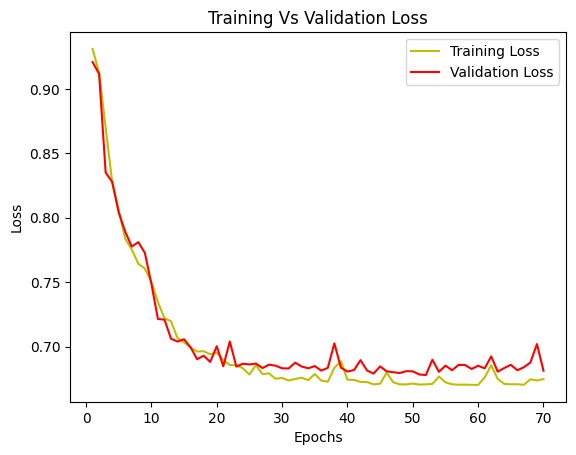

In [109]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

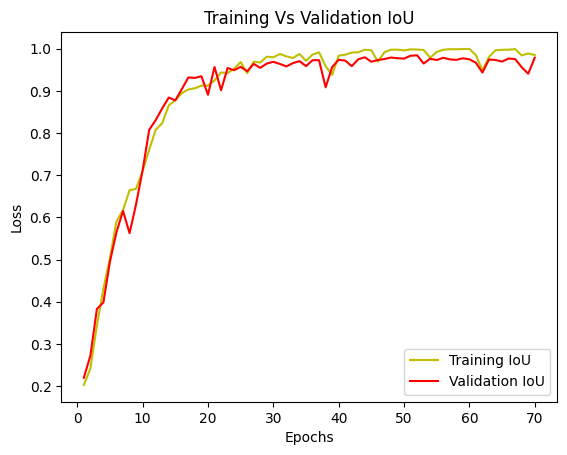

In [110]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

##Model 2 with 100 epoch and 32 batch size

In [111]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [112]:
model = get_deep_learning_model()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [113]:
#accuracy of train dataset
model_history2 = model.fit(X_train, y_train,
                          batch_size=32, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=100, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

Epoch 1/100
53/53 [==============================] - 18s 317ms/step - loss: 0.9324 - accuracy: 0.3380 - jaccard_coef: 0.2001 - val_loss: 0.9305 - val_accuracy: 0.3672 - val_jaccard_coef: 0.2023
Epoch 2/100
53/53 [==============================] - 16s 299ms/step - loss: 0.9217 - accuracy: 0.4265 - jaccard_coef: 0.2240 - val_loss: 0.9192 - val_accuracy: 0.4658 - val_jaccard_coef: 0.2562
Epoch 3/100
53/53 [==============================] - 16s 300ms/step - loss: 0.8454 - accuracy: 0.6551 - jaccard_coef: 0.4041 - val_loss: 0.7923 - val_accuracy: 0.8190 - val_jaccard_coef: 0.5144
Epoch 4/100
53/53 [==============================] - 16s 300ms/step - loss: 0.7755 - accuracy: 0.8193 - jaccard_coef: 0.6138 - val_loss: 0.7518 - val_accuracy: 0.8638 - val_jaccard_coef: 0.6781
Epoch 5/100
53/53 [==============================] - 16s 309ms/step - loss: 0.7400 - accuracy: 0.8884 - jaccard_coef: 0.7456 - val_loss: 0.7413 - val_accuracy: 0.8931 - val_jaccard_coef: 0.7189
Epoch 6/100
53/53 [===========

In [115]:
# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# If you specifically want to access accuracy
test_accuracy = test_results[model.metrics_names.index('accuracy')]
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

loss: 0.6805
accuracy: 0.9880
jaccard_coef: 0.9769

Testing Accuracy: 0.9880


In [117]:
# Evaluate the model on the train dataset
train_results = model.evaluate(X_train, y_train, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {train_results[i]:.4f}")

# If you specifically want to access accuracy
train_accuracy = train_results[model.metrics_names.index('accuracy')]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

loss: 0.6702
accuracy: 0.9998
jaccard_coef: 0.9994

Training Accuracy: 0.9998


23/23 [==============================] - 1s 44ms/step


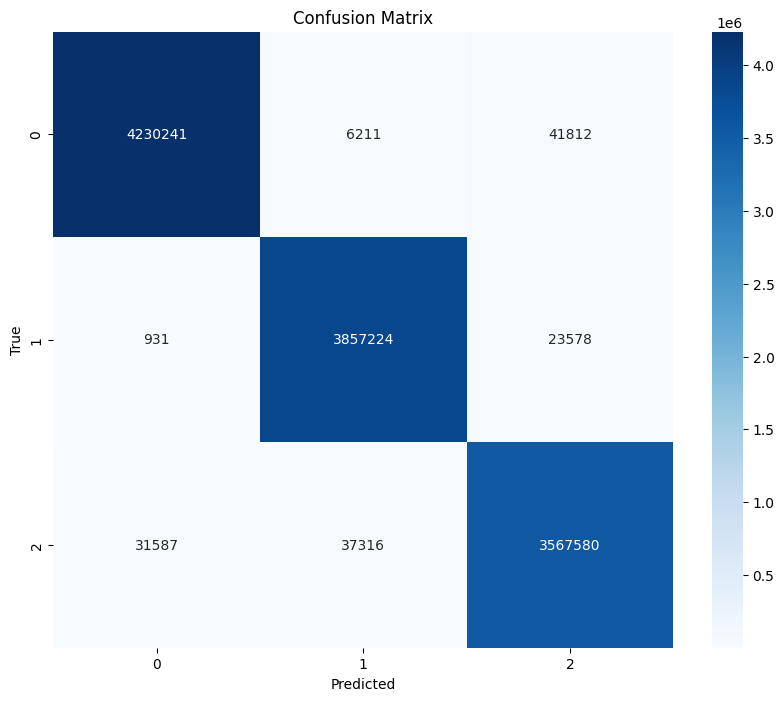

                   precision    recall  f1-score   support

      Agriculture       0.99      0.99      0.99   4278264
          Housing       0.99      0.99      0.99   3881733
Native Vegetation       0.98      0.98      0.98   3636483

         accuracy                           0.99  11796480
        macro avg       0.99      0.99      0.99  11796480
     weighted avg       0.99      0.99      0.99  11796480



In [118]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test, axis=3)

# Flatten the 2D arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Agriculture', 'Housing', 'Native Vegetation']))

In [119]:
for i, label in enumerate(['Agriculture', 'Housing', 'Native Vegetation']):
  label_accuracy = (y_pred_classes == i).astype(int) == (y_true == i).astype(int)
  label_accuracy = label_accuracy.mean() * 100
  print(f"{label} Accuracy: {label_accuracy:.2f}%")

Agriculture Accuracy: 99.32%
Housing Accuracy: 99.42%
Native Vegetation Accuracy: 98.86%


In [120]:
model_history = model_history2
history_a = model_history
history_a.history

{'loss': [0.9324437975883484,
  0.9217209815979004,
  0.845379650592804,
  0.7754567265510559,
  0.7399518489837646,
  0.7426736950874329,
  0.7300355434417725,
  0.7195833921432495,
  0.7169173359870911,
  0.7164511680603027,
  0.709121823310852,
  0.7052918076515198,
  0.709246814250946,
  0.7042336463928223,
  0.7019526362419128,
  0.6965142488479614,
  0.6977751851081848,
  0.7006309032440186,
  0.6985774636268616,
  0.6954736709594727,
  0.6873612403869629,
  0.6886633038520813,
  0.688148558139801,
  0.689670741558075,
  0.6863004565238953,
  0.6837644577026367,
  0.6835033893585205,
  0.6994120478630066,
  0.682746946811676,
  0.6860570311546326,
  0.6792873740196228,
  0.6784029006958008,
  0.6776059865951538,
  0.6759520173072815,
  0.6761544942855835,
  0.6749312877655029,
  0.6759709119796753,
  0.6770724058151245,
  0.673374593257904,
  0.6761288642883301,
  0.6747975945472717,
  0.6774114966392517,
  0.6764377951622009,
  0.6754666566848755,
  0.6726588010787964,
  0.67334

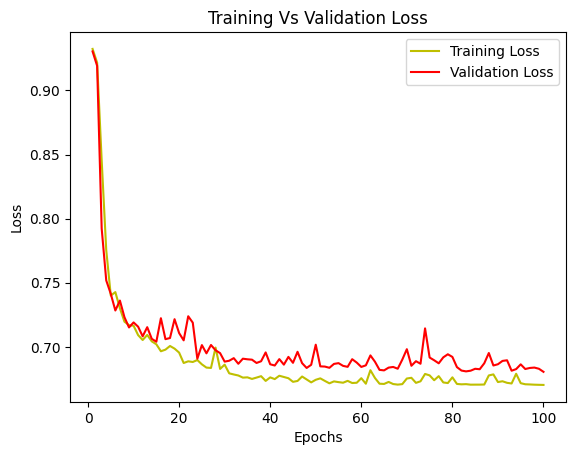

In [121]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

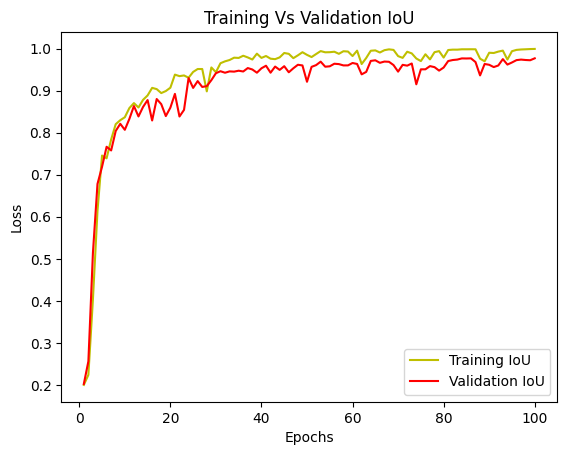

In [122]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

##Model 3 with 70 epoch and 16 batch size

In [123]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [124]:
model = get_deep_learning_model()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
#accuracy of train dataset
model_history3 = model.fit(X_train, y_train,
                          batch_size=16, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=70, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

Epoch 1/70
105/105 [==============================] - 21s 184ms/step - loss: 0.9315 - accuracy: 0.3793 - jaccard_coef: 0.2059 - val_loss: 0.9340 - val_accuracy: 0.3777 - val_jaccard_coef: 0.2081
Epoch 2/70
105/105 [==============================] - 19s 181ms/step - loss: 0.9086 - accuracy: 0.5186 - jaccard_coef: 0.2558 - val_loss: 0.8927 - val_accuracy: 0.5738 - val_jaccard_coef: 0.3041
Epoch 3/70
105/105 [==============================] - 18s 175ms/step - loss: 0.8708 - accuracy: 0.6859 - jaccard_coef: 0.3435 - val_loss: 0.8732 - val_accuracy: 0.7260 - val_jaccard_coef: 0.3886
Epoch 4/70
105/105 [==============================] - 18s 174ms/step - loss: 0.8562 - accuracy: 0.7172 - jaccard_coef: 0.3779 - val_loss: 0.8114 - val_accuracy: 0.7723 - val_jaccard_coef: 0.5410
Epoch 5/70
105/105 [==============================] - 18s 175ms/step - loss: 0.7983 - accuracy: 0.7908 - jaccard_coef: 0.5788 - val_loss: 0.7732 - val_accuracy: 0.8351 - val_jaccard_coef: 0.6100
Epoch 6/70
105/105 [=====

In [126]:
# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# If you specifically want to access accuracy
test_accuracy = test_results[model.metrics_names.index('accuracy')]
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

loss: 0.7036
accuracy: 0.9693
jaccard_coef: 0.9276

Testing Accuracy: 0.9693


In [127]:
# Evaluate the model on the train dataset
train_results = model.evaluate(X_train, y_train, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {train_results[i]:.4f}")

# If you specifically want to access accuracy
train_accuracy = train_results[model.metrics_names.index('accuracy')]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

loss: 0.6804
accuracy: 0.9903
jaccard_coef: 0.9696

Training Accuracy: 0.9903


23/23 [==============================] - 1s 42ms/step


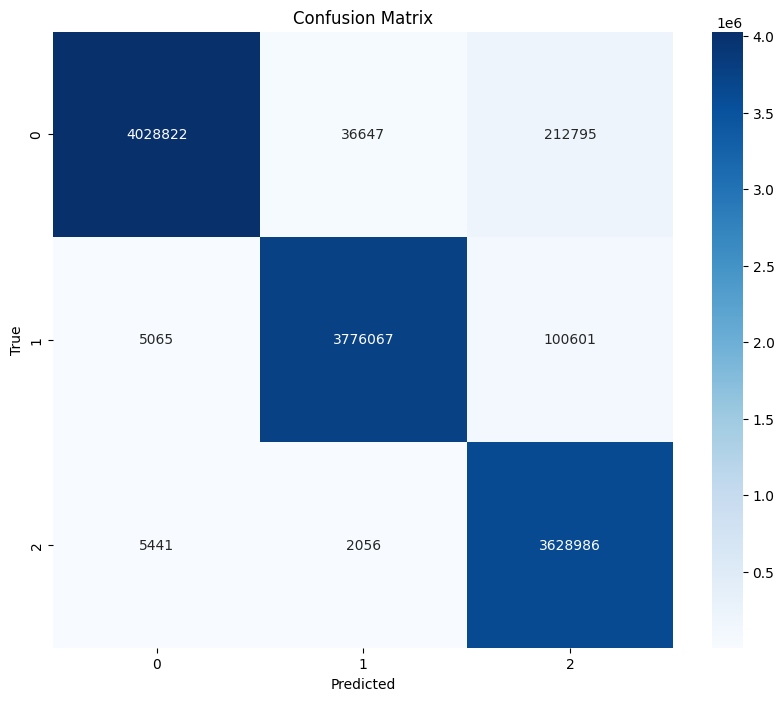

                   precision    recall  f1-score   support

      Agriculture       1.00      0.94      0.97   4278264
          Housing       0.99      0.97      0.98   3881733
Native Vegetation       0.92      1.00      0.96   3636483

         accuracy                           0.97  11796480
        macro avg       0.97      0.97      0.97  11796480
     weighted avg       0.97      0.97      0.97  11796480



In [128]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test, axis=3)

# Flatten the 2D arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Agriculture', 'Housing', 'Native Vegetation']))

In [129]:
for i, label in enumerate(['Agriculture', 'Housing', 'Native Vegetation']):
  label_accuracy = (y_pred_classes == i).astype(int) == (y_true == i).astype(int)
  label_accuracy = label_accuracy.mean() * 100
  print(f"{label} Accuracy: {label_accuracy:.2f}%")

Agriculture Accuracy: 97.80%
Housing Accuracy: 98.78%
Native Vegetation Accuracy: 97.28%


In [130]:
model_history = model_history3
history_a = model_history
history_a.history

{'loss': [0.9314900636672974,
  0.9086284637451172,
  0.8707642555236816,
  0.8561949133872986,
  0.7983302474021912,
  0.7552911639213562,
  0.7329398989677429,
  0.720055878162384,
  0.7283254861831665,
  0.7142521739006042,
  0.7120029330253601,
  0.7085883021354675,
  0.7078939080238342,
  0.7091224789619446,
  0.70293128490448,
  0.706838071346283,
  0.6973257660865784,
  0.6983274221420288,
  0.6978517770767212,
  0.7031151652336121,
  0.7116051316261292,
  0.7055090069770813,
  0.6924666166305542,
  0.6931120157241821,
  0.6937640905380249,
  0.6901749968528748,
  0.6883620619773865,
  0.6890750527381897,
  0.6879876852035522,
  0.683893084526062,
  0.6828189492225647,
  0.6905994415283203,
  0.6888059377670288,
  0.688716471195221,
  0.6856325268745422,
  0.6844894886016846,
  0.6843225955963135,
  0.680773138999939,
  0.678238034248352,
  0.6950476765632629,
  0.6880592703819275,
  0.6892209053039551,
  0.6783475875854492,
  0.6851765513420105,
  0.6806546449661255,
  0.678927

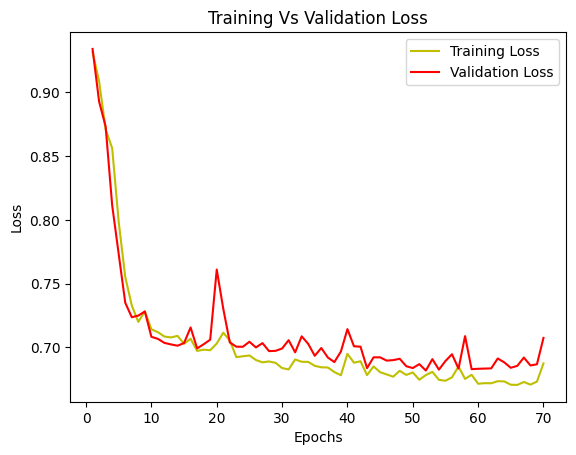

In [131]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

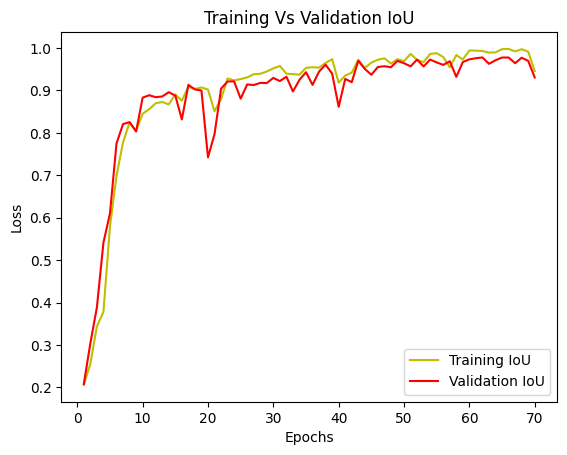

In [132]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

##Model 4 with 100 epoch and 16 batch size

In [133]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [134]:
model = get_deep_learning_model()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [135]:
#accuracy of train dataset
model_history4 = model.fit(X_train, y_train,
                          batch_size=16, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=100, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)

Epoch 1/100
105/105 [==============================] - 21s 181ms/step - loss: 0.9266 - accuracy: 0.4146 - jaccard_coef: 0.2154 - val_loss: 0.8833 - val_accuracy: 0.5202 - val_jaccard_coef: 0.3125
Epoch 2/100
105/105 [==============================] - 18s 174ms/step - loss: 0.8568 - accuracy: 0.6331 - jaccard_coef: 0.3880 - val_loss: 0.8205 - val_accuracy: 0.6914 - val_jaccard_coef: 0.4566
Epoch 3/100
105/105 [==============================] - 19s 177ms/step - loss: 0.7991 - accuracy: 0.7734 - jaccard_coef: 0.5594 - val_loss: 0.8428 - val_accuracy: 0.6770 - val_jaccard_coef: 0.4449
Epoch 4/100
105/105 [==============================] - 18s 174ms/step - loss: 0.7593 - accuracy: 0.8610 - jaccard_coef: 0.6961 - val_loss: 0.7829 - val_accuracy: 0.8105 - val_jaccard_coef: 0.6561
Epoch 5/100
105/105 [==============================] - 18s 175ms/step - loss: 0.7424 - accuracy: 0.8896 - jaccard_coef: 0.7582 - val_loss: 0.7849 - val_accuracy: 0.8128 - val_jaccard_coef: 0.6534
Epoch 6/100
105/105 

In [136]:
# Evaluate the model on the test dataset
test_results = model.evaluate(X_test, y_test, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# If you specifically want to access accuracy
test_accuracy = test_results[model.metrics_names.index('accuracy')]
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

loss: 0.6773
accuracy: 0.9924
jaccard_coef: 0.9852

Testing Accuracy: 0.9924


In [137]:
# Evaluate the model on the train dataset
train_results = model.evaluate(X_train, y_train, verbose=0)

# Print all the metrics
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {train_results[i]:.4f}")

# If you specifically want to access accuracy
train_accuracy = train_results[model.metrics_names.index('accuracy')]
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

loss: 0.6703
accuracy: 0.9998
jaccard_coef: 0.9992

Training Accuracy: 0.9998


23/23 [==============================] - 1s 45ms/step


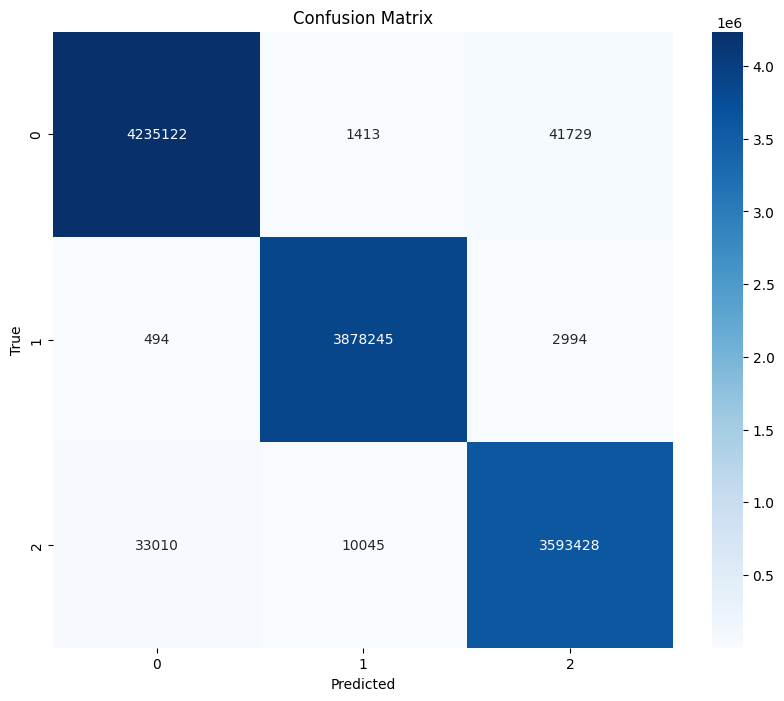

                   precision    recall  f1-score   support

      Agriculture       0.99      0.99      0.99   4278264
          Housing       1.00      1.00      1.00   3881733
Native Vegetation       0.99      0.99      0.99   3636483

         accuracy                           0.99  11796480
        macro avg       0.99      0.99      0.99  11796480
     weighted avg       0.99      0.99      0.99  11796480



In [138]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=3)
y_true = np.argmax(y_test, axis=3)

# Flatten the 2D arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true.flatten()

# Create confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Agriculture', 'Housing', 'Native Vegetation']))

In [139]:
for i, label in enumerate(['Agriculture', 'Housing', 'Native Vegetation']):
  label_accuracy = (y_pred_classes == i).astype(int) == (y_true == i).astype(int)
  label_accuracy = label_accuracy.mean() * 100
  print(f"{label} Accuracy: {label_accuracy:.2f}%")

Agriculture Accuracy: 99.35%
Housing Accuracy: 99.87%
Native Vegetation Accuracy: 99.26%


In [140]:
model_history = model_history4
history_a = model_history
history_a.history

{'loss': [0.9265583753585815,
  0.8567817807197571,
  0.7990511655807495,
  0.7592835426330566,
  0.7423585653305054,
  0.7355901598930359,
  0.735838770866394,
  0.7232414484024048,
  0.7187091708183289,
  0.7130403518676758,
  0.7123153805732727,
  0.7095615267753601,
  0.7050437331199646,
  0.7115654945373535,
  0.7021448016166687,
  0.6983535289764404,
  0.6953863501548767,
  0.6917041540145874,
  0.6915876269340515,
  0.6880285143852234,
  0.6913332343101501,
  0.6952505111694336,
  0.687304675579071,
  0.6807416081428528,
  0.6827020645141602,
  0.6868847012519836,
  0.6827303171157837,
  0.6806675791740417,
  0.6861270666122437,
  0.6806925535202026,
  0.6823470592498779,
  0.6815266013145447,
  0.6772650480270386,
  0.6771103739738464,
  0.6770306825637817,
  0.674647331237793,
  0.681564211845398,
  0.6746369004249573,
  0.6746878027915955,
  0.6851621270179749,
  0.674615740776062,
  0.6728555560112,
  0.6771751642227173,
  0.6813377141952515,
  0.6811811327934265,
  0.679684

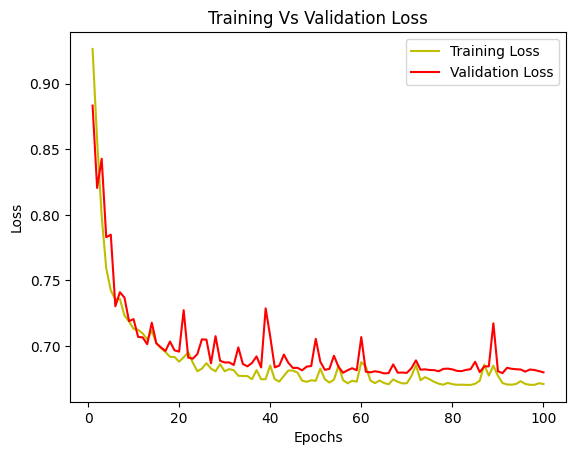

In [141]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

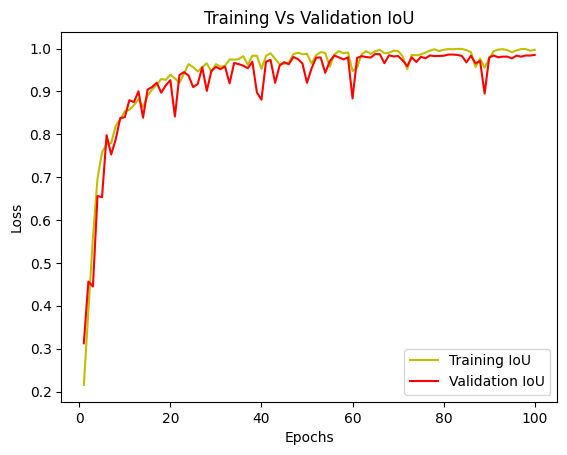

In [142]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

### Model end

In [143]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 105}

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

NameError: name 'X_train' is not defined

#Comparing prediction results


*   using test images using images and predicted result images



In [2]:
import random

test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test[test_image_number]
prediction_image = model.predict(np.expand_dims(test_image, axis=0))[0]
predicted_class_image = np.argmax(prediction_image, axis=-1)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_image)
plt.axis('off')

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(np.argmax(ground_truth_image, axis=-1), cmap='viridis')
plt.axis('off')

plt.subplot(133)
plt.title('Prediction')
plt.imshow(predicted_class_image, cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report

y_pred_flat = predicted_class_image.flatten()
y_true_flat = np.argmax(ground_truth_image, axis=-1).flatten()

print(classification_report(y_true_flat, y_pred_flat, target_names=['Agriculture', 'Housing', 'Native Vegetation']))

# Calculate per-label accuracy
for i, label in enumerate(['Agriculture', 'Housing', 'Native Vegetation']):
    label_accuracy = (predicted_class_image == i).astype(int) == (np.argmax(ground_truth_image, axis=-1) == i).astype(int)
    label_accuracy = label_accuracy.mean() * 100
    print(f"{label} Accuracy: {label_accuracy:.2f}%")

NameError: name 'X_test' is not defined

In [1]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_pred_classes[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

NameError: name 'random' is not defined

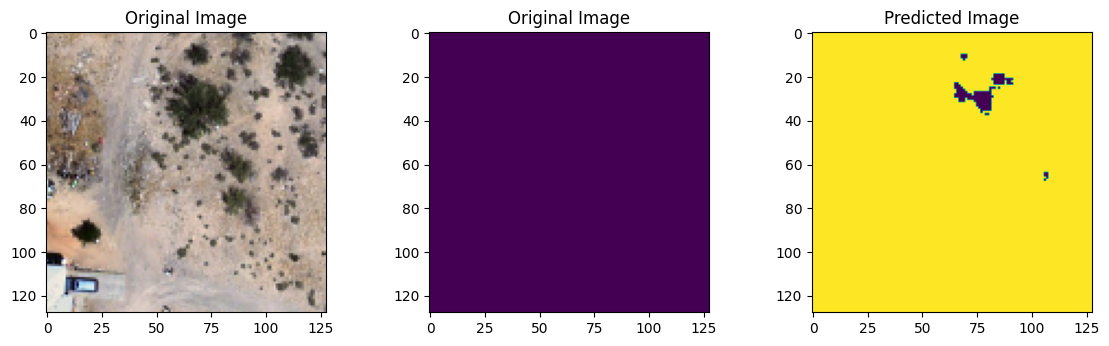

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

#Model save and reload

In [ ]:
from keras.models import load_model

In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
saved_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
#saved_model.get_config()

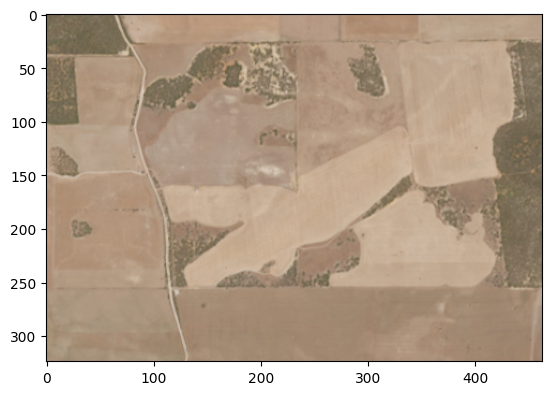

In [ ]:
img = os.path.join(base_input_folder, "image-1.tiff")
plt.imshow(Image.open(img))

In [ ]:
original_image = Image.open(img)
def create_patches(image, patch_size=128):
  width, height = image.size
  patches = []
  for i in range(0, height, patch_size):
      for j in range(0, width, patch_size):
          patch = image.crop((j, i, j+patch_size, i+patch_size))
          patch_array = np.array(patch)
          patches.append(patch_array)
  return np.array(patches)

# Create patches
patches = create_patches(original_image)

In [ ]:
patches.shape

(12, 128, 128, 3)

In [ ]:
prediction = saved_model.predict(patches)
#predicted_image = np.argmax(prediction, axis=3)
#predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 186ms/step


In [ ]:
prediction

array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 1.8594281e-09, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 3.5526260e-33, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.000

In [ ]:
# Get the class with highest probability for each pixel
predicted_classes = np.argmax(prediction, axis=3)

# Reconstruct the full image from patches
def reconstruct_from_patches(patches, original_size):
  height, width = original_size
  reconstructed = np.zeros((height, width), dtype=np.uint8)
  patch_size = patches.shape[1]
  index = 0
  for i in range(0, height - patch_size + 1, patch_size): # Adjust loop range to avoid going out of bounds
      for j in range(0, width - patch_size + 1, patch_size):
          reconstructed[i:i+patch_size, j:j+patch_size] = patches[index]
          index += 1
  return reconstructed

predicted_image = reconstruct_from_patches(predicted_classes, original_image.size)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [ ]:
# Create a custom colormap
colors = [color_mapping[i] for i in range(4)]  # Assuming 4 classes (0 to 3)
custom_cmap = mcolors.ListedColormap(colors)

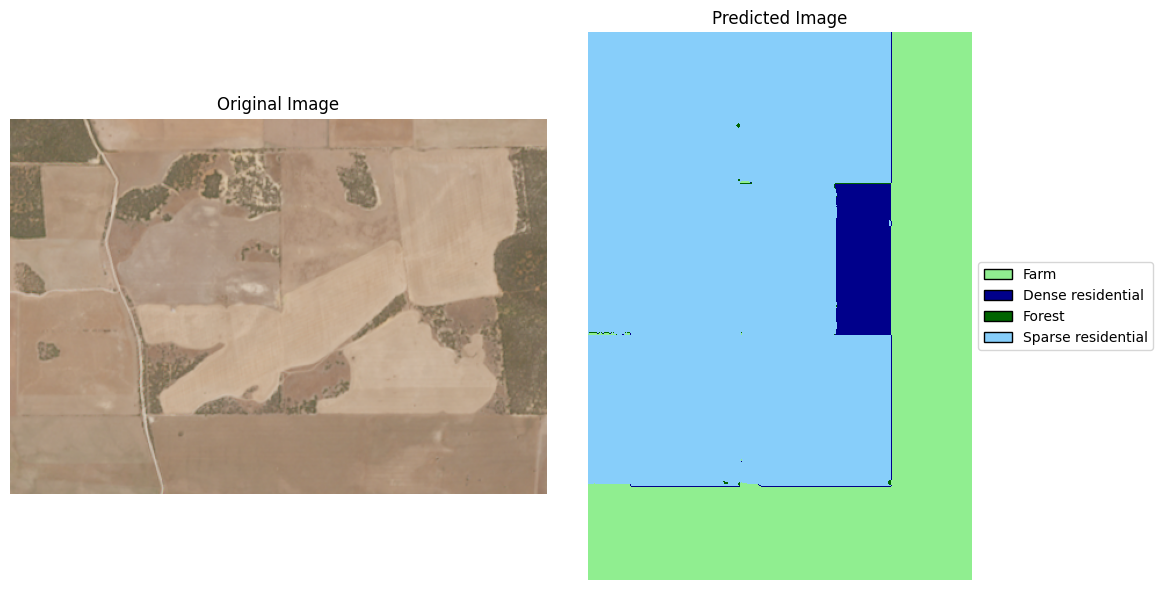

In [ ]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(121)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Predicted Image
plt.subplot(122)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=custom_cmap, vmin=0, vmax=3)  # You might want to use a different colormap
plt.axis('off')

# Create custom legend
legend_elements = [mpatches.Patch(facecolor=color_mapping[i], edgecolor='black',
                                label=list(label_mapping.keys())[i].capitalize())
                 for i in range(4)]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
print(f"Original image size: {original_image.size}")
print(f"Original image size: {predicted_image.size}")



Original image size: (463, 324)
Original image size: 150012
